# DDIM vs WGAN: Exploratory Data Analysis

## Comparing Generative Models on Flowers102 and MNIST Datasets

This notebook analyzes and compares the performance of **DDIM (Denoising Diffusion Implicit Models)** and **WGAN (Wasserstein GAN)** across two different datasets:
- **Oxford Flowers102**: 102 flower categories with complex, colorful images
- **MNIST**: Handwritten digits (simpler, grayscale images)

### Models Compared:
- **DDIM**: Denoising Diffusion Implicit Models
- **WGAN-Fast**: Wasserstein GAN with fast training configuration
- **WGAN-Quality**: Wasserstein GAN with enhanced training for better image quality

### Key Metrics Analyzed:
- **KID (Kernel Inception Distance)**: Lower is better - measures image quality
- **Training Time**: Time per epoch and total training time
- **Sampling Time**: Time to generate images during inference


In [53]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for beautiful visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configure plot aesthetics
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [54]:
# Load all datasets
data_dir = Path("data")

# Load DDIM data
ddim_flowers_raw = pd.read_csv(data_dir / "ddim_flowers_metrics.csv")
ddim_mnist_raw = pd.read_csv(data_dir / "ddim_mnist_metrics.csv")

# Load WGAN data (Fast)
wgan_flowers_raw = pd.read_csv(data_dir / "wgan_flowers_metrics.csv")
wgan_mnist_raw = pd.read_csv(data_dir / "wgan_mnist_metrics.csv")

# Load WGAN data (Quality - trained longer/better)
wgan_flowers_quality_raw = pd.read_csv(data_dir / "wgan_flowers_metrics_quality.csv")
wgan_mnist_quality_raw = pd.read_csv(data_dir / "wgan_mnist_metrics_quality.csv")

print("Data files loaded:")
print(f"  - DDIM Flowers: {len(ddim_flowers_raw)} rows")
print(f"  - DDIM MNIST: {len(ddim_mnist_raw)} rows")
print(f"  - WGAN Flowers (Fast): {len(wgan_flowers_raw)} rows")
print(f"  - WGAN MNIST (Fast): {len(wgan_mnist_raw)} rows")
print(f"  - WGAN Flowers (Quality): {len(wgan_flowers_quality_raw)} rows")
print(f"  - WGAN MNIST (Quality): {len(wgan_mnist_quality_raw)} rows")


Data files loaded:
  - DDIM Flowers: 50 rows
  - DDIM MNIST: 50 rows
  - WGAN Flowers (Fast): 50 rows
  - WGAN MNIST (Fast): 50 rows
  - WGAN Flowers (Quality): 50 rows
  - WGAN MNIST (Quality): 50 rows


In [55]:
# Standardize column names and create clean dataframes
# DDIM data uses: epoch, epoch_time, sampling_time, val_kid
# WGAN data uses: Epoch, KID, Training_Time_Sec/Training_Time, Sampling_Time_Sec/Sampling_Time

def standardize_ddim(df, dataset_name):
    """Standardize DDIM dataframe columns"""
    # Handle different column names (sampling vs sampling_time)
    sampling_col = 'sampling_time' if 'sampling_time' in df.columns else 'sampling'
    
    # Keep only relevant columns and first 50 rows (training data)
    clean_df = df[['epoch', 'epoch_time', sampling_col, 'val_kid']].head(50).copy()
    clean_df.columns = ['epoch', 'training_time', 'sampling_time', 'kid']
    
    # Convert all columns to numeric (handles string data issues)
    clean_df['epoch'] = pd.to_numeric(clean_df['epoch'], errors='coerce')
    clean_df['training_time'] = pd.to_numeric(clean_df['training_time'], errors='coerce')
    clean_df['sampling_time'] = pd.to_numeric(clean_df['sampling_time'], errors='coerce')
    clean_df['kid'] = pd.to_numeric(clean_df['kid'], errors='coerce')
    
    # Drop any rows with NaN values (from conversion errors)
    clean_df = clean_df.dropna()
    
    clean_df['epoch'] = clean_df['epoch'] + 1  # Convert 0-indexed to 1-indexed
    clean_df['model'] = 'DDIM'
    clean_df['dataset'] = dataset_name
    return clean_df

def standardize_wgan(df, dataset_name, model_name='WGAN'):
    """Standardize WGAN dataframe columns"""
    clean_df = df.copy()
    # Normalize column names (handle different naming conventions)
    clean_df.columns = clean_df.columns.str.lower().str.replace('_sec', '').str.replace('_', ' ')
    clean_df = clean_df.rename(columns={
        'training time': 'training_time',
        'sampling time': 'sampling_time'
    })
    clean_df = clean_df[['epoch', 'kid', 'training_time', 'sampling_time']].copy()
    
    # Convert all columns to numeric
    clean_df['epoch'] = pd.to_numeric(clean_df['epoch'], errors='coerce')
    clean_df['kid'] = pd.to_numeric(clean_df['kid'], errors='coerce')
    clean_df['training_time'] = pd.to_numeric(clean_df['training_time'], errors='coerce')
    clean_df['sampling_time'] = pd.to_numeric(clean_df['sampling_time'], errors='coerce')
    
    # Drop any rows with NaN values
    clean_df = clean_df.dropna()
    
    clean_df['model'] = model_name
    clean_df['dataset'] = dataset_name
    return clean_df

# Create standardized dataframes
ddim_flowers = standardize_ddim(ddim_flowers_raw, 'Flowers102')
ddim_mnist = standardize_ddim(ddim_mnist_raw, 'MNIST')

# Fast WGAN
wgan_flowers = standardize_wgan(wgan_flowers_raw, 'Flowers102', 'WGAN-Fast')
wgan_mnist = standardize_wgan(wgan_mnist_raw, 'MNIST', 'WGAN-Fast')

# Quality WGAN
wgan_flowers_quality = standardize_wgan(wgan_flowers_quality_raw, 'Flowers102', 'WGAN-Quality')
wgan_mnist_quality = standardize_wgan(wgan_mnist_quality_raw, 'MNIST', 'WGAN-Quality')

# Combine all data into one master dataframe
all_data = pd.concat([
    ddim_flowers, ddim_mnist, 
    wgan_flowers, wgan_mnist,
    wgan_flowers_quality, wgan_mnist_quality
], ignore_index=True)

print("Standardized data sample:")
print(all_data.head(10))
print(f"\nTotal records: {len(all_data)}")
print(f"\nModels included: {sorted(all_data['model'].unique())}")
print(f"Datasets included: {sorted(all_data['dataset'].unique())}")


Standardized data sample:
   epoch  training_time  sampling_time       kid model     dataset
0      1     111.222537       2.215010  0.545885  DDIM  Flowers102
1      2      43.767640       2.186949  0.549467  DDIM  Flowers102
2      3      43.827313       2.231452  0.548270  DDIM  Flowers102
3      4      44.976223       2.196438  0.512232  DDIM  Flowers102
4      5      45.023357       2.209701  0.478733  DDIM  Flowers102
5      6      44.937134       2.202125  0.474414  DDIM  Flowers102
6      7      44.924638       2.196970  0.339046  DDIM  Flowers102
7      8      44.967196       2.188110  0.235594  DDIM  Flowers102
8      9      46.038071       2.218176  0.169603  DDIM  Flowers102
9     10      45.313262       2.215234  0.113953  DDIM  Flowers102

Total records: 300

Models included: ['DDIM', 'WGAN-Fast', 'WGAN-Quality']
Datasets included: ['Flowers102', 'MNIST']


## 2. Summary Statistics


In [56]:
# Calculate summary statistics for each model-dataset combination
summary_stats = all_data.groupby(['model', 'dataset']).agg({
    'kid': ['min', 'max', 'mean', 'std'],
    'training_time': ['min', 'max', 'mean', 'sum'],
    'sampling_time': ['min', 'max', 'mean', 'sum']
}).round(4)

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

print("=" * 80)
print("SUMMARY STATISTICS BY MODEL AND DATASET")
print("=" * 80)
print(summary_stats.to_string())
print("=" * 80)


SUMMARY STATISTICS BY MODEL AND DATASET
                         kid_min  kid_max  kid_mean  kid_std  training_time_min  training_time_max  training_time_mean  training_time_sum  sampling_time_min  sampling_time_max  sampling_time_mean  sampling_time_sum
model        dataset                                                                                                                                                                                                  
DDIM         Flowers102   0.0495   0.5495    0.1222   0.1564            43.5983           111.2225             45.7583          2287.9145             2.1487             2.2315              2.1917           109.5874
             MNIST        0.0162   0.5908    0.0603   0.1269            65.2771           132.9138             67.4514          3372.5689             2.1679             2.2217              2.1907           109.5340
WGAN-Fast    Flowers102   0.2165   0.6500    0.3744   0.1361             5.0616            11.9760  

In [57]:
# Create a clean comparison table
comparison_data = []

for dataset in ['Flowers102', 'MNIST']:
    for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        if len(subset) > 0:  # Check if data exists for this combination
            comparison_data.append({
                'Dataset': dataset,
                'Model': model,
                'Best KID': subset['kid'].min(),
                'Final KID (Epoch 50)': subset[subset['epoch'] == 50]['kid'].values[0] if len(subset[subset['epoch'] == 50]) > 0 else subset['kid'].iloc[-1],
                'Avg Training Time (s)': subset['training_time'].mean(),
                'Total Training Time (min)': subset['training_time'].sum() / 60,
                'Avg Sampling Time (s)': subset['sampling_time'].mean(),
            })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 MODEL COMPARISON TABLE")
print("=" * 120)
print(comparison_df.to_string(index=False))
print("=" * 120)



📊 MODEL COMPARISON TABLE
   Dataset        Model  Best KID  Final KID (Epoch 50)  Avg Training Time (s)  Total Training Time (min)  Avg Sampling Time (s)
Flowers102         DDIM  0.049474              0.050693              45.758289                  38.131908               2.191748
Flowers102    WGAN-Fast  0.216477              0.229667               5.295573                   4.412978               0.353075
Flowers102 WGAN-Quality  0.117318              0.118487              61.710495                  51.425413               0.350389
     MNIST         DDIM  0.016218              0.017346              67.451379                  56.209482               2.190680
     MNIST    WGAN-Fast  0.018233              0.025319              41.160730                  34.300608               0.344506
     MNIST WGAN-Quality  0.012068              0.014087             574.634400                 478.862000               0.317600


In [58]:
# # How to access KID from a specific epoch in the dataframe

# # Method 1: Get KID for a specific epoch (across all models/datasets)
# epoch_10 = all_data[all_data['epoch'] == 10]['kid']
# print("KID values at epoch 10 (all models/datasets):")
# print(epoch_10)
# print()

# # Method 2: Get KID for a specific model, dataset, and epoch
# ddim_flowers_epoch_10 = all_data[(all_data['model'] == 'DDIM') & 
#                                   (all_data['dataset'] == 'Flowers102') & 
#                                   (all_data['epoch'] == 10)]['kid'].values[0]
# print(f"DDIM Flowers102 at epoch 10: KID = {ddim_flowers_epoch_10:.6f}")
# print()

# # Method 3: Get KID using .loc (more explicit)
# kid_value = all_data.loc[(all_data['model'] == 'WGAN') & 
#                          (all_data['dataset'] == 'MNIST') & 
#                          (all_data['epoch'] == 25), 'kid'].values[0]
# print(f"WGAN MNIST at epoch 25: KID = {kid_value:.6f}")
# print()

# # Method 4: Get all KID values for a specific model-dataset across epochs
# ddim_flowers_all = all_data[(all_data['model'] == 'DDIM') & 
#                             (all_data['dataset'] == 'Flowers102')][['epoch', 'kid']]
# print("DDIM Flowers102 - All epochs and KID values:")
# print(ddim_flowers_all.head(10))
# print()

# # Method 5: Create a lookup function
# def get_kid(model, dataset, epoch):
#     """Get KID value for a specific model, dataset, and epoch"""
#     result = all_data[(all_data['model'] == model) & 
#                      (all_data['dataset'] == dataset) & 
#                      (all_data['epoch'] == epoch)]
#     if len(result) > 0:
#         return result['kid'].values[0]
#     else:
#         return None

# # Example usage
# print("Using lookup function:")
# print(f"DDIM Flowers102 epoch 33: {get_kid('DDIM', 'Flowers102', 33):.6f}")
# print(f"WGAN MNIST epoch 50: {get_kid('WGAN', 'MNIST', 50):.6f}")


In [59]:
# Get the min KID and epoch for each model-dataset combination

# Method 1: Using idxmin() to get the index of minimum KID for each group
min_kid_info = all_data.loc[all_data.groupby(['model', 'dataset'])['kid'].idxmin()][['model', 'dataset', 'epoch', 'kid']].copy()
min_kid_info.columns = ['Model', 'Dataset', 'Epoch', 'Min_KID']
min_kid_info = min_kid_info.sort_values(['Dataset', 'Model']).reset_index(drop=True)

print("=" * 70)
print("MINIMUM KID SCORE AND EPOCH FOR EACH MODEL-DATASET COMBINATION")
print("=" * 70)
print(min_kid_info.to_string(index=False))
print("=" * 70)

# Method 2: Alternative approach - detailed breakdown with additional info
print("\n" + "=" * 70)
print("DETAILED BREAKDOWN:")
print("=" * 70)
for (model, dataset), group in all_data.groupby(['model', 'dataset']):
    min_kid = group['kid'].min()
    min_kid_row = group[group['kid'] == min_kid].iloc[0]
    print(f"\n{model} - {dataset}:")
    print(f"  Minimum KID: {min_kid:.6f}")
    print(f"  Achieved at Epoch: {int(min_kid_row['epoch'])}")
    print(f"  Training Time at that epoch: {min_kid_row['training_time']:.2f}s")
    print(f"  Sampling Time at that epoch: {min_kid_row['sampling_time']:.2f}s")


MINIMUM KID SCORE AND EPOCH FOR EACH MODEL-DATASET COMBINATION
       Model    Dataset  Epoch  Min_KID
        DDIM Flowers102     34 0.049474
   WGAN-Fast Flowers102     49 0.216477
WGAN-Quality Flowers102     45 0.117318
        DDIM      MNIST     10 0.016218
   WGAN-Fast      MNIST     48 0.018233
WGAN-Quality      MNIST     34 0.012068

DETAILED BREAKDOWN:

DDIM - Flowers102:
  Minimum KID: 0.049474
  Achieved at Epoch: 34
  Training Time at that epoch: 44.89s
  Sampling Time at that epoch: 2.17s

DDIM - MNIST:
  Minimum KID: 0.016218
  Achieved at Epoch: 10
  Training Time at that epoch: 67.05s
  Sampling Time at that epoch: 2.18s

WGAN-Fast - Flowers102:
  Minimum KID: 0.216477
  Achieved at Epoch: 49
  Training Time at that epoch: 5.10s
  Sampling Time at that epoch: 0.31s

WGAN-Fast - MNIST:
  Minimum KID: 0.018233
  Achieved at Epoch: 48
  Training Time at that epoch: 40.73s
  Sampling Time at that epoch: 0.29s

WGAN-Quality - Flowers102:
  Minimum KID: 0.117318
  Achieved at

## 3. KID Score Analysis

**KID (Kernel Inception Distance)** measures the quality of generated images compared to real images. Lower KID values indicate better image quality and more realistic generations.


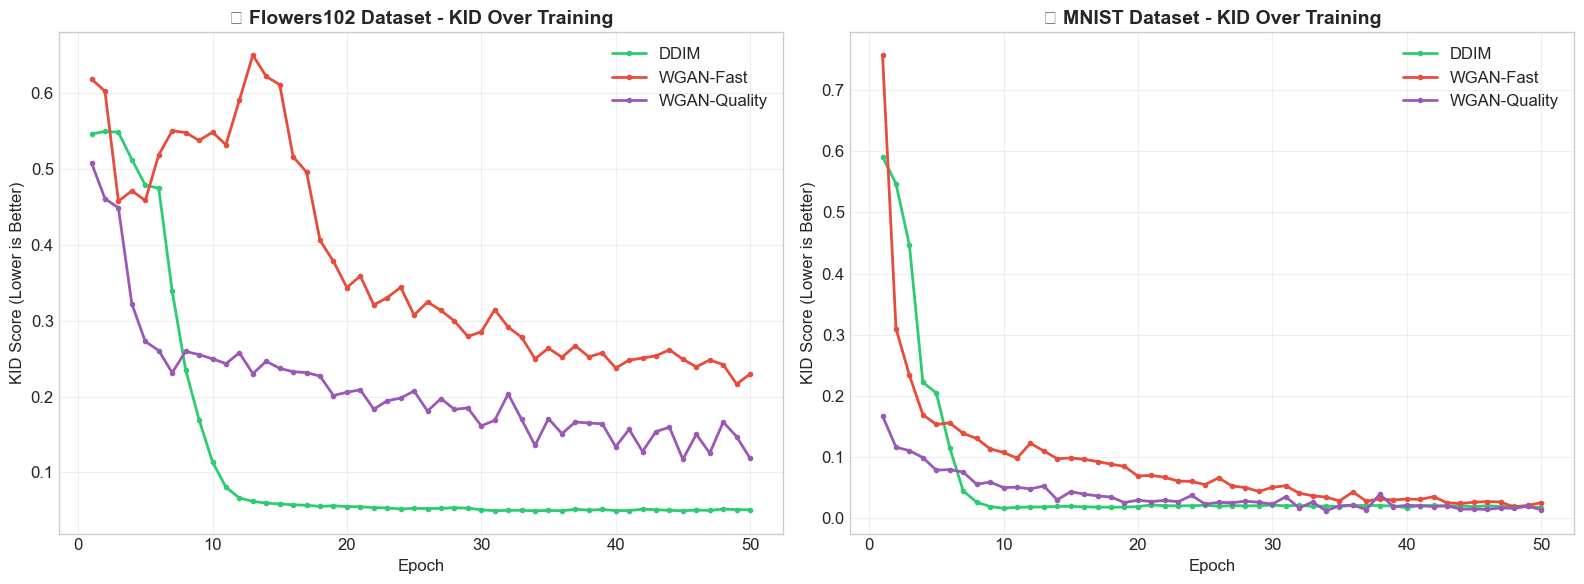

📁 Saved: kid_comparison.png


In [60]:
# KID Score Over Epochs - Side by Side Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors for models
colors = {'DDIM': '#2ecc71', 'WGAN-Fast': '#e74c3c', 'WGAN-Quality': '#9b59b6'}

# Plot Flowers102
ax1 = axes[0]
for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
    data = all_data[(all_data['dataset'] == 'Flowers102') & (all_data['model'] == model)]
    if len(data) > 0:
        ax1.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2, marker='o', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('KID Score (Lower is Better)')
ax1.set_title('🌸 Flowers102 Dataset - KID Over Training', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MNIST
ax2 = axes[1]
for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
    data = all_data[(all_data['dataset'] == 'MNIST') & (all_data['model'] == model)]
    if len(data) > 0:
        ax2.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2, marker='o', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('KID Score (Lower is Better)')
ax2.set_title('🔢 MNIST Dataset - KID Over Training', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kid_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: kid_comparison.png")


In [61]:
def get_kid(model, dataset, epoch):
    result = all_data[(all_data['model'] == model) & 
                     (all_data['dataset'] == dataset) & 
                     (all_data['epoch'] == epoch)]
    return result['kid'].values[0] if len(result) > 0 else None

# Use it
kid = get_kid('DDIM', 'Flowers102', 10)
print(f"KID for DDIM on Flowers102 at epoch 10: {kid}")


KID for DDIM on Flowers102 at epoch 10: 0.113952659


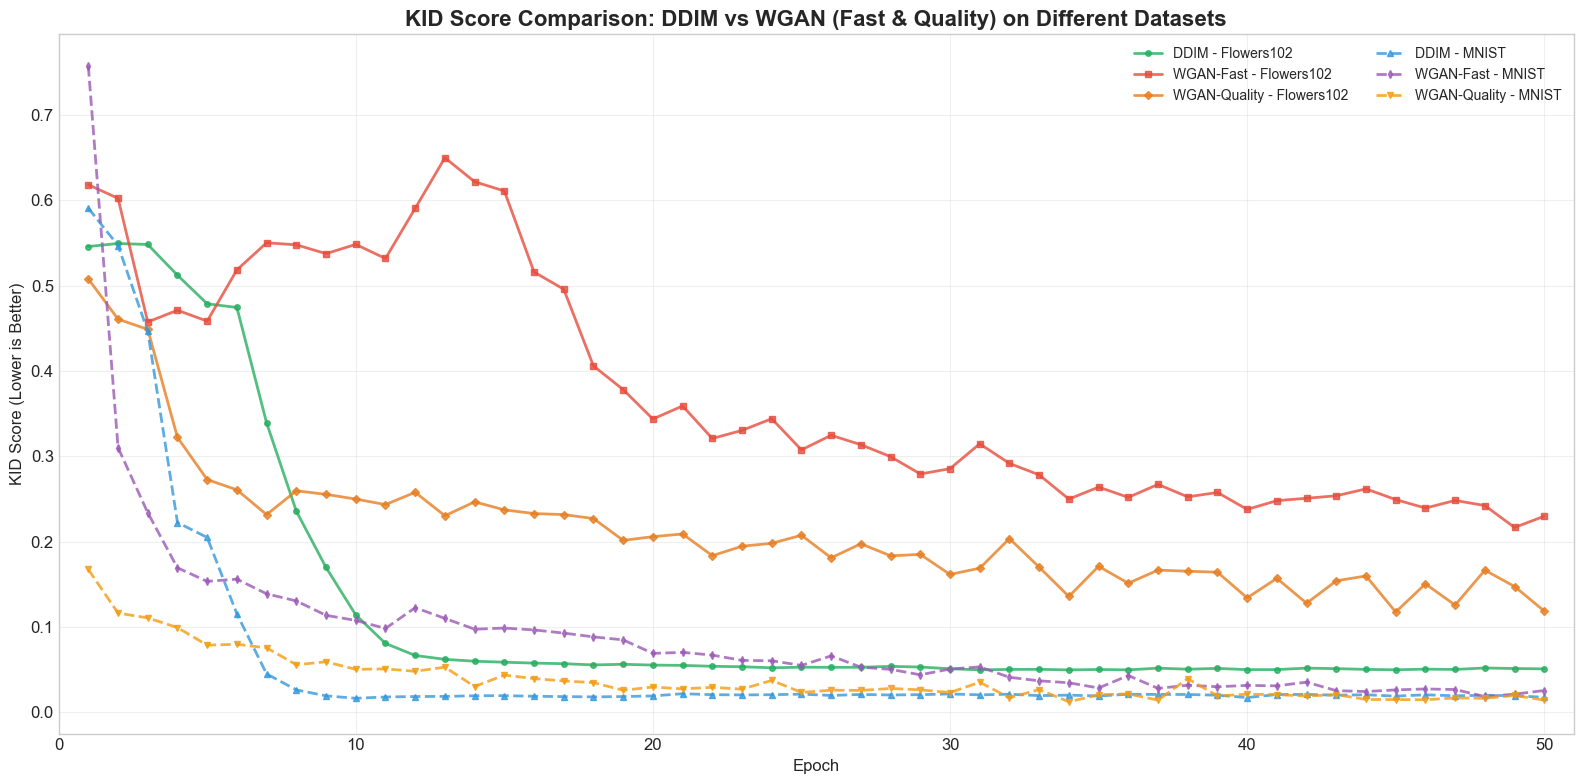

📁 Saved: kid_all_models.png


In [62]:
# Combined KID Comparison - All in One Plot
fig, ax = plt.subplots(figsize=(16, 8))

# Define styles for each combination
styles = {
    ('DDIM', 'Flowers102'): {'color': '#27ae60', 'linestyle': '-', 'marker': 'o'},
    ('WGAN-Fast', 'Flowers102'): {'color': '#e74c3c', 'linestyle': '-', 'marker': 's'},
    ('WGAN-Quality', 'Flowers102'): {'color': '#e67e22', 'linestyle': '-', 'marker': 'D'},
    ('DDIM', 'MNIST'): {'color': '#3498db', 'linestyle': '--', 'marker': '^'},
    ('WGAN-Fast', 'MNIST'): {'color': '#9b59b6', 'linestyle': '--', 'marker': 'd'},
    ('WGAN-Quality', 'MNIST'): {'color': '#f39c12', 'linestyle': '--', 'marker': 'v'},
}

for (model, dataset), style in styles.items():
    data = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
    if len(data) > 0:
        ax.plot(data['epoch'], data['kid'], 
                label=f'{model} - {dataset}', 
                color=style['color'], 
                linestyle=style['linestyle'],
                marker=style['marker'],
                markersize=4,
                linewidth=2,
                alpha=0.8)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('KID Score (Lower is Better)', fontsize=12)
ax.set_title('KID Score Comparison: DDIM vs WGAN (Fast & Quality) on Different Datasets', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 51)

plt.tight_layout()
plt.savefig('kid_all_models.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: kid_all_models.png")


## 4. Training Time Analysis

Comparing the computational cost of training each model.


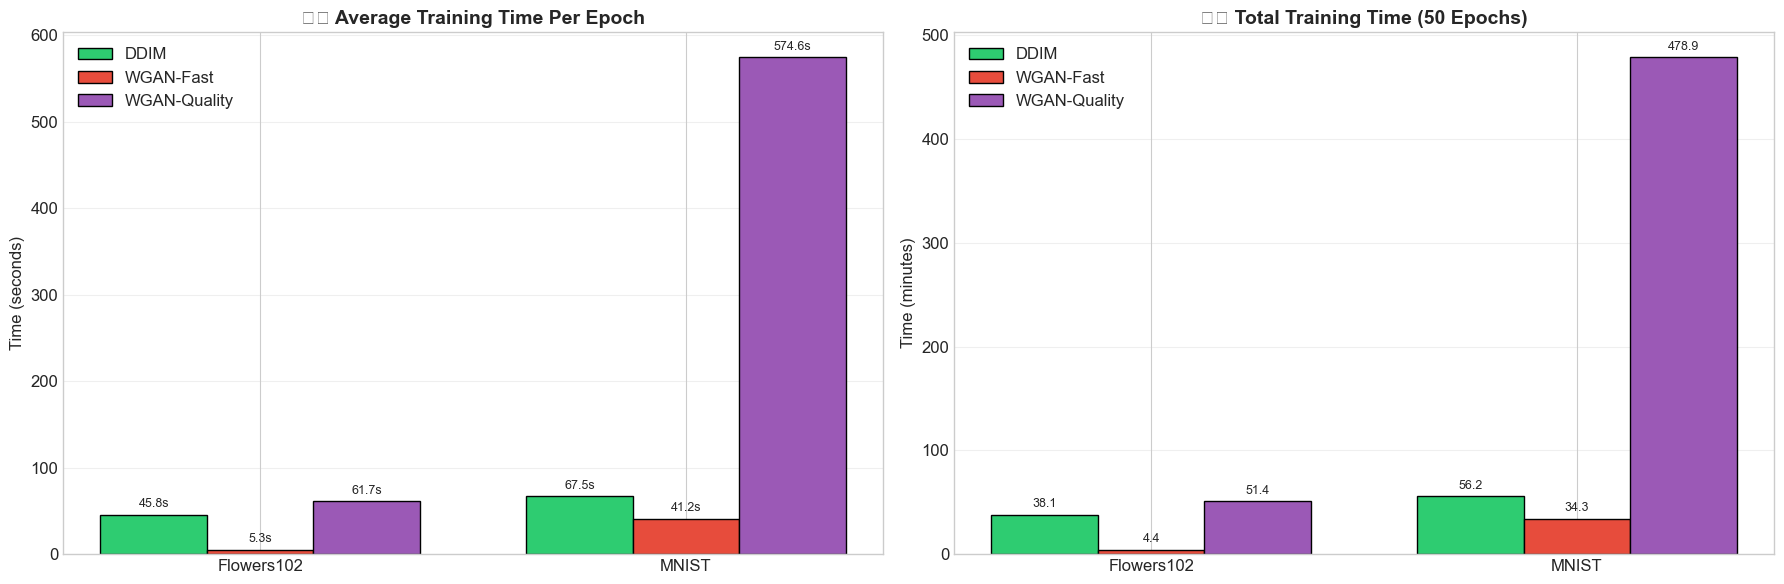

📁 Saved: training_time_comparison.png


In [ ]:
# Training Time Comparison - Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Calculate average and total training times
training_summary = all_data.groupby(['model', 'dataset']).agg({
    'training_time': ['mean', 'sum']
}).reset_index()
training_summary.columns = ['Model', 'Dataset', 'Avg Time (s)', 'Total Time (s)']
training_summary['Total Time (min)'] = training_summary['Total Time (s)'] / 60

# Average Training Time Per Epoch
ax1 = axes[0]
x = np.arange(2)
width = 0.25

ddim_avg = training_summary[training_summary['Model'] == 'DDIM']['Avg Time (s)'].values
wgan_fast_avg = training_summary[training_summary['Model'] == 'WGAN-Fast']['Avg Time (s)'].values
wgan_qual_avg = training_summary[training_summary['Model'] == 'WGAN-Quality']['Avg Time (s)'].values

bars1 = ax1.bar(x - width, ddim_avg, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x, wgan_fast_avg, width, label='WGAN-Fast', color='#e74c3c', edgecolor='black')
bars3 = ax1.bar(x + width, wgan_qual_avg, width, label='WGAN-Quality', color='#9b59b6', edgecolor='black')

ax1.set_ylabel('Time (seconds)')
ax1.set_title('⏱️ Average Training Time Per Epoch', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Flowers102', 'MNIST'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Total Training Time (50 epochs)
ax2 = axes[1]
ddim_total = training_summary[training_summary['Model'] == 'DDIM']['Total Time (min)'].values
wgan_fast_total = training_summary[training_summary['Model'] == 'WGAN-Fast']['Total Time (min)'].values
wgan_qual_total = training_summary[training_summary['Model'] == 'WGAN-Quality']['Total Time (min)'].values

bars4 = ax2.bar(x - width, ddim_total, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars5 = ax2.bar(x, wgan_fast_total, width, label='WGAN-Fast', color='#e74c3c', edgecolor='black')
bars6 = ax2.bar(x + width, wgan_qual_total, width, label='WGAN-Quality', color='#9b59b6', edgecolor='black')

ax2.set_ylabel('Time (minutes)')
ax2.set_title('⏱️ Total Training Time (50 Epochs)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Flowers102', 'MNIST'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars4, bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f} min', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: training_time_comparison.png")


## 5. Sampling Time Analysis

Comparing how fast each model can generate new images after training.


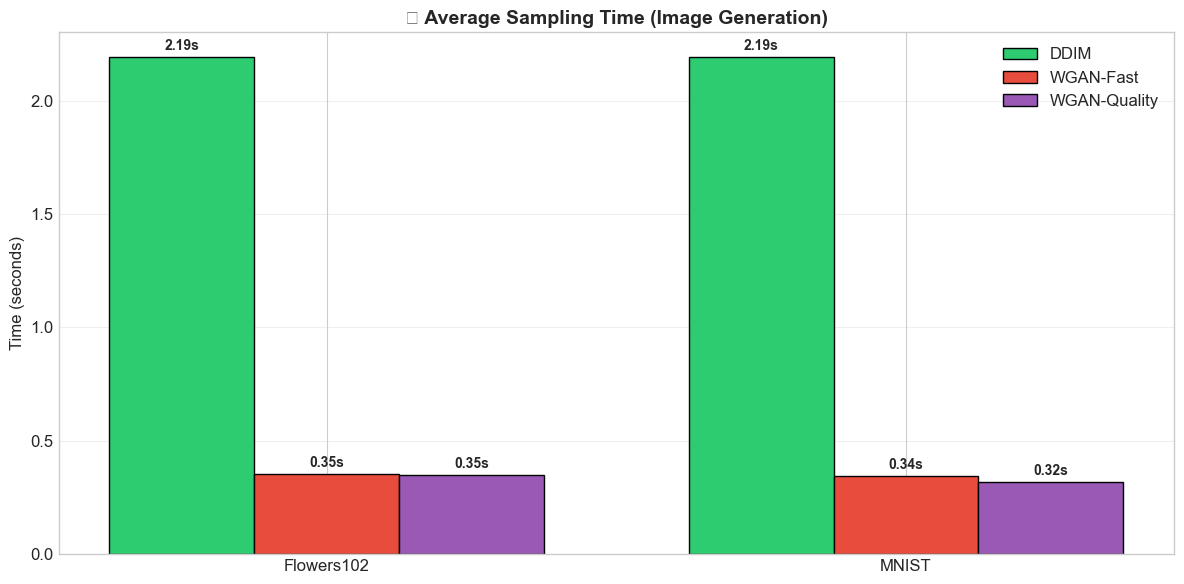

📁 Saved: sampling_time_comparison.png


In [64]:
# Sampling Time Comparison
fig, ax = plt.subplots(figsize=(12, 6))

sampling_summary = all_data.groupby(['model', 'dataset'])['sampling_time'].mean().reset_index()
sampling_summary.columns = ['Model', 'Dataset', 'Avg Sampling Time (s)']

x = np.arange(2)
width = 0.25

ddim_samp = sampling_summary[sampling_summary['Model'] == 'DDIM']['Avg Sampling Time (s)'].values
wgan_fast_samp = sampling_summary[sampling_summary['Model'] == 'WGAN-Fast']['Avg Sampling Time (s)'].values
wgan_qual_samp = sampling_summary[sampling_summary['Model'] == 'WGAN-Quality']['Avg Sampling Time (s)'].values

bars1 = ax.bar(x - width, ddim_samp, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, wgan_fast_samp, width, label='WGAN-Fast', color='#e74c3c', edgecolor='black')
bars3 = ax.bar(x + width, wgan_qual_samp, width, label='WGAN-Quality', color='#9b59b6', edgecolor='black')

ax.set_ylabel('Time (seconds)')
ax.set_title('🎨 Average Sampling Time (Image Generation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Flowers102', 'MNIST'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('sampling_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: sampling_time_comparison.png")


### Why DDIM Sampling Times Are Nearly Identical for Flowers102 and MNIST

An interesting observation: **DDIM sampling times are almost identical** (~2.19s) for both Flowers102 and MNIST datasets, despite Flowers102 being a more complex dataset. Here's why:


In [65]:
# Explanation: Why DDIM sampling times are the same for Flowers102 and MNIST

print("=" * 80)
print("WHY DDIM SAMPLING TIMES ARE THE SAME FOR FLOWERS102 AND MNIST")
print("=" * 80)
print("""
The sampling time for DDIM models is determined by several key factors:

1. IMAGE RESOLUTION:
   - Both models use: 64×64 pixels
   - Even though Flowers102 has more complex content, both are resized to the same resolution
   - Same resolution = same computational cost per image

2. NUMBER OF DIFFUSION STEPS:
   - Both models use: 20 diffusion steps (kid_diffusion_steps = 20)
   - Each step requires a forward pass through the neural network
   - Same number of steps = same number of forward passes

3. BATCH SIZE DURING SAMPLING:
   - Both models generate: 64 images per sampling batch (batch_size = 64)
   - Same batch size = same parallel computation

4. MODEL ARCHITECTURE:
   - Both models use identical architecture:
     * widths = [32, 64, 96, 128]
     * block_depth = 2
   - Same architecture = same computational complexity per forward pass

5. SAMPLING MEASUREMENT:
   - Sampling time is measured during KID evaluation in train_step()
   - Both generate batch_size images using kid_diffusion_steps
   - Identical measurement conditions

CONCLUSION:
The sampling time is dominated by the computational parameters (resolution, steps, 
batch size, architecture) rather than the dataset complexity. Since all these 
parameters are identical between the two DDIM models, the sampling times are 
nearly identical (~2.19s).

Note: The dataset complexity (color vs grayscale, texture variety) affects the 
MODEL'S LEARNING CAPABILITY and FINAL IMAGE QUALITY, but not the computational 
cost of the sampling process itself, which is fixed by the architecture and 
hyperparameters.
""")
print("=" * 80)

# Show the actual values
print("\n📊 COMPARISON OF KEY PARAMETERS:")
print("-" * 80)
comparison_params = pd.DataFrame({
    'Parameter': ['Image Size', 'Diffusion Steps', 'Batch Size', 'Model Widths', 'Block Depth'],
    'Flowers102': ['64×64', '20', '64', '[32, 64, 96, 128]', '2'],
    'MNIST': ['64×64', '20', '64', '[32, 64, 96, 128]', '2']
})
print(comparison_params.to_string(index=False))
print("-" * 80)


WHY DDIM SAMPLING TIMES ARE THE SAME FOR FLOWERS102 AND MNIST

The sampling time for DDIM models is determined by several key factors:

1. IMAGE RESOLUTION:
   - Both models use: 64×64 pixels
   - Even though Flowers102 has more complex content, both are resized to the same resolution
   - Same resolution = same computational cost per image

2. NUMBER OF DIFFUSION STEPS:
   - Both models use: 20 diffusion steps (kid_diffusion_steps = 20)
   - Each step requires a forward pass through the neural network
   - Same number of steps = same number of forward passes

3. BATCH SIZE DURING SAMPLING:
   - Both models generate: 64 images per sampling batch (batch_size = 64)
   - Same batch size = same parallel computation

4. MODEL ARCHITECTURE:
   - Both models use identical architecture:
     * widths = [32, 64, 96, 128]
     * block_depth = 2
   - Same architecture = same computational complexity per forward pass

5. SAMPLING MEASUREMENT:
   - Sampling time is measured during KID evaluation in

## 6. Comprehensive Dashboard


Debug: all_data columns: ['epoch', 'training_time', 'sampling_time', 'kid', 'model', 'dataset']
Debug: all_data shape: (300, 6)
Debug: unique models: ['DDIM' 'WGAN-Fast' 'WGAN-Quality']
Debug: unique datasets: ['Flowers102' 'MNIST']
Debug: eff_df columns: ['Model', 'Dataset', 'Efficiency']


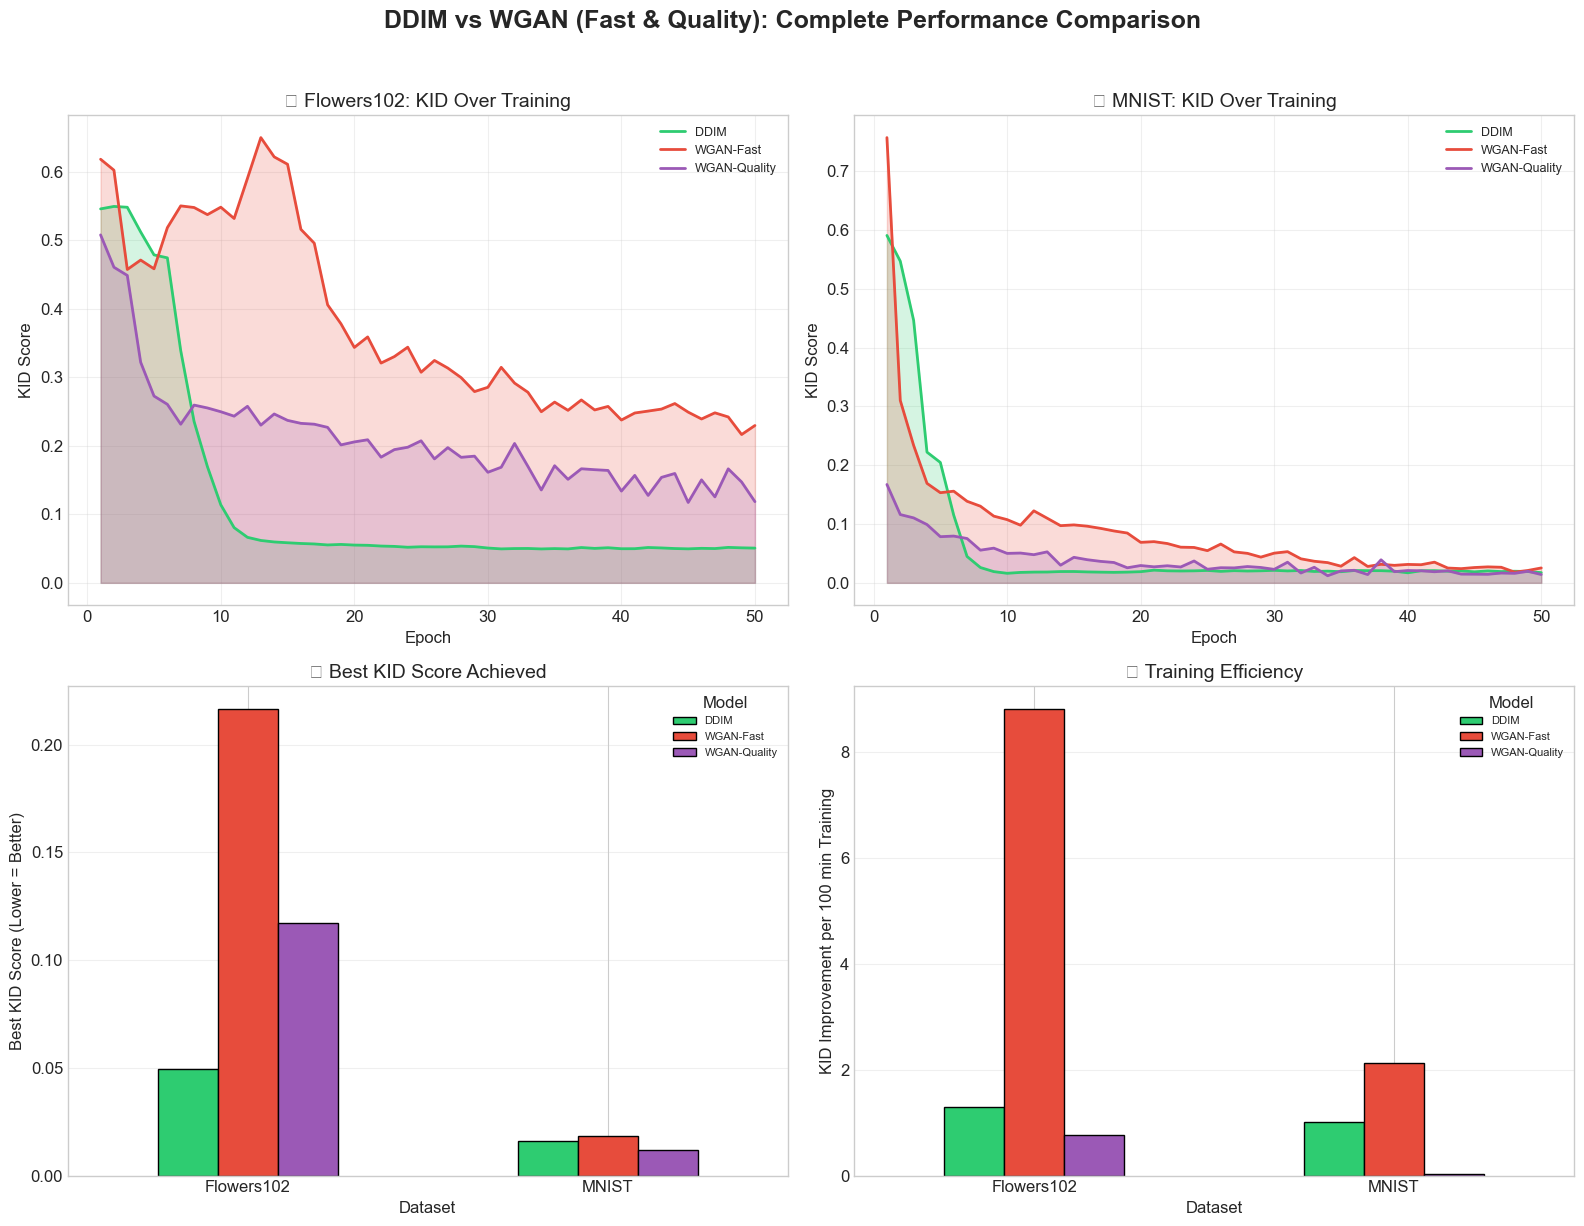

📁 Saved: comprehensive_dashboard.png


In [66]:
# Create comprehensive 2x2 dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DDIM vs WGAN (Fast & Quality): Complete Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

colors = {'DDIM': '#2ecc71', 'WGAN-Fast': '#e74c3c', 'WGAN-Quality': '#9b59b6'}

# Debug: Check data structure
print("Debug: all_data columns:", all_data.columns.tolist())
print("Debug: all_data shape:", all_data.shape)
print("Debug: unique models:", all_data['model'].unique())
print("Debug: unique datasets:", all_data['dataset'].unique())

# 1. KID over epochs - Flowers102
ax1 = axes[0, 0]
for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
    data = all_data[(all_data['dataset'] == 'Flowers102') & (all_data['model'] == model)]
    if len(data) > 0:
        ax1.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2)
        ax1.fill_between(data['epoch'], data['kid'], alpha=0.2, color=colors[model])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('KID Score')
ax1.set_title('🌸 Flowers102: KID Over Training')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. KID over epochs - MNIST
ax2 = axes[0, 1]
for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
    data = all_data[(all_data['dataset'] == 'MNIST') & (all_data['model'] == model)]
    if len(data) > 0:
        ax2.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2)
        ax2.fill_between(data['epoch'], data['kid'], alpha=0.2, color=colors[model])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('KID Score')
ax2.set_title('🔢 MNIST: KID Over Training')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Best KID Comparison (Bar)
ax3 = axes[1, 0]
best_kid = all_data.groupby(['model', 'dataset'])['kid'].min().reset_index()
# Ensure we have all combinations
best_kid_pivot = best_kid.pivot(index='dataset', columns='model', values='kid')
# Reindex to ensure all datasets and models are present
best_kid_pivot = best_kid_pivot.reindex(['Flowers102', 'MNIST'])
# Only plot columns that exist
plot_cols = [col for col in ['DDIM', 'WGAN-Fast', 'WGAN-Quality'] if col in best_kid_pivot.columns]
if len(plot_cols) > 0:
    best_kid_pivot[plot_cols].plot(kind='bar', ax=ax3, color=[colors[col] for col in plot_cols], edgecolor='black')
ax3.set_xlabel('Dataset')
ax3.set_ylabel('Best KID Score (Lower = Better)')
ax3.set_title('🏆 Best KID Score Achieved')
ax3.legend(title='Model', fontsize=8)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Training Efficiency (KID improvement per minute)
ax4 = axes[1, 1]
efficiency_data = []
for dataset in ['Flowers102', 'MNIST']:
    for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        if len(subset) > 0:  # Check if data exists
            initial_kid = subset['kid'].iloc[0]
            final_kid = subset['kid'].iloc[-1]
            total_time_min = subset['training_time'].sum() / 60
            improvement = initial_kid - final_kid
            efficiency = improvement / total_time_min * 100 if total_time_min > 0 else 0  # KID improvement per 100 min
            efficiency_data.append({'Model': model, 'Dataset': dataset, 'Efficiency': efficiency})

eff_df = pd.DataFrame(efficiency_data)
if len(eff_df) > 0:
    # Check what columns actually exist
    print("Debug: eff_df columns:", eff_df.columns.tolist())
    # Use lowercase to match the actual column names
    pivot_index = 'Dataset' if 'Dataset' in eff_df.columns else 'dataset'
    pivot_col = 'Model' if 'Model' in eff_df.columns else 'model'
    pivot_val = 'Efficiency' if 'Efficiency' in eff_df.columns else 'efficiency'
    
    eff_pivot = eff_df.pivot(index=pivot_index, columns=pivot_col, values=pivot_val)
    # Reindex to ensure all datasets are present
    eff_pivot = eff_pivot.reindex(['Flowers102', 'MNIST'])
    # Only plot columns that exist
    plot_cols = [col for col in ['DDIM', 'WGAN-Fast', 'WGAN-Quality'] if col in eff_pivot.columns]
    if len(plot_cols) > 0:
        eff_pivot[plot_cols].plot(kind='bar', ax=ax4, color=[colors[col] for col in plot_cols], edgecolor='black')
ax4.set_xlabel('Dataset')
ax4.set_ylabel('KID Improvement per 100 min Training')
ax4.set_title('⚡ Training Efficiency')
ax4.legend(title='Model', fontsize=8)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comprehensive_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: comprehensive_dashboard.png")


## 7. Key Findings & Conclusions


In [ ]:
# Generate Key Findings Report
print("=" * 100)
print("📊 KEY FINDINGS: DDIM vs WGAN (Fast & Quality) COMPARISON")
print("=" * 100)

# Calculate key metrics
findings = {}
for dataset in ['Flowers102', 'MNIST']:
    findings[dataset] = {}
    for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        if len(subset) > 0:
            findings[dataset][model] = {
                'best_kid': subset['kid'].min(),
                'final_kid': subset['kid'].iloc[-1],
                'avg_train_time': subset['training_time'].mean(),
                'total_train_time': subset['training_time'].sum() / 60,
                'avg_sample_time': subset['sampling_time'].mean()
            }

# Print findings
for dataset in ['Flowers102', 'MNIST']:
    print(f"\n{'🌸' if dataset == 'Flowers102' else '🔢'} {dataset.upper()} DATASET:")
    print("-" * 80)
    
    ddim = findings[dataset]['DDIM']
    wgan_fast = findings[dataset]['WGAN-Fast']
    wgan_qual = findings[dataset]['WGAN-Quality']
    
    # KID Comparison
    print(f"  🏆 Image Quality (KID - Lower is Better):")
    print(f"     - DDIM:         {ddim['best_kid']:.4f}")
    print(f"     - WGAN-Fast:    {wgan_fast['best_kid']:.4f}")
    print(f"     - WGAN-Quality: {wgan_qual['best_kid']:.4f}")
    best_model = min(findings[dataset].items(), key=lambda x: x[1]['best_kid'])[0]
    print(f"     ➜ Winner: {best_model}")
    
    # Training Time
    print(f"\n  ⏱️  Total Training Time (50 epochs):")
    print(f"     - DDIM:         {ddim['total_train_time']:.1f} min")
    print(f"     - WGAN-Fast:    {wgan_fast['total_train_time']:.1f} min")
    print(f"     - WGAN-Quality: {wgan_qual['total_train_time']:.1f} min")
    fastest_model = min(findings[dataset].items(), key=lambda x: x[1]['total_train_time'])[0]
    print(f"     ➜ Fastest: {fastest_model}")
    
    # Sampling Time
    print(f"\n  🎨 Average Sampling Time:")
    print(f"     - DDIM:         {ddim['avg_sample_time']:.2f}s")
    print(f"     - WGAN-Fast:    {wgan_fast['avg_sample_time']:.2f}s")
    print(f"     - WGAN-Quality: {wgan_qual['avg_sample_time']:.2f}s")
    fastest_sample = min(findings[dataset].items(), key=lambda x: x[1]['avg_sample_time'])[0]
    print(f"     ➜ Fastest: {fastest_sample}")

print("\n" + "=" * 100)
print("📝 SUMMARY CONCLUSIONS:")
print("=" * 100)
print("""
1. IMAGE QUALITY (KID):
   - DDIM consistently achieves the best KID scores on both datasets
   - WGAN-Quality shows significant improvement over WGAN-Fast
   - WGAN-Quality achieves competitive quality with much longer training times

2. TRAINING TIME:
   - WGAN-Fast is fastest but produces lower quality images
   - WGAN-Quality takes significantly longer than both DDIM and WGAN-Fast
   - Trade-off between training time and image quality is evident

3. SAMPLING TIME:
   - Both WGAN versions are ~6-7x faster at generating images (single forward pass)
   - DDIM requires multiple denoising steps, resulting in slower sampling
   - For inference/deployment, WGAN has clear advantage in speed

4. QUALITY vs SPEED TRADE-OFF:
   - WGAN-Fast: Fast training, fast sampling, but lower quality
   - WGAN-Quality: Slow training, fast sampling, better quality
   - DDIM: Medium training time, slow sampling, best quality
   
5. RECOMMENDATION:
   - Use DDIM when: Highest quality is priority, sampling speed is less critical
   - Use WGAN-Quality when: Need fast inference with good quality, training time is flexible
   - Use WGAN-Fast when: Need quick prototyping and fast inference, quality is acceptable
""")


📊 KEY FINDINGS: DDIM vs WGAN (Fast & Quality) COMPARISON

🌸 FLOWERS102 DATASET:
--------------------------------------------------------------------------------
  🏆 Image Quality (KID - Lower is Better):
     - DDIM:         0.0495
     - WGAN-Fast:    0.2165
     - WGAN-Quality: 0.1173
     ➜ Winner: DDIM

  ⏱️  Total Training Time (50 epochs):
     - DDIM:         38.1 min
     - WGAN-Fast:    4.4 min
     - WGAN-Quality: 51.4 min
     ➜ Fastest: WGAN-Fast

  🎨 Average Sampling Time:
     - DDIM:         2.19s
     - WGAN-Fast:    0.35s
     - WGAN-Quality: 0.35s
     ➜ Fastest: WGAN-Quality

🔢 MNIST DATASET:
--------------------------------------------------------------------------------
  🏆 Image Quality (KID - Lower is Better):
     - DDIM:         0.0162
     - WGAN-Fast:    0.0182
     - WGAN-Quality: 0.0121
     ➜ Winner: WGAN-Quality

  ⏱️  Total Training Time (50 epochs):
     - DDIM:         56.2 min
     - WGAN-Fast:    34.3 min
     - WGAN-Quality: 478.9 min
     ➜ Fastest

In [68]:
# Export final comparison table
final_table_data = []
for dataset in ['Flowers102', 'MNIST']:
    for model in ['DDIM', 'WGAN-Fast', 'WGAN-Quality']:
        if model in findings[dataset]:
            final_table_data.append({
                'Dataset': dataset,
                'Model': model,
                'Best KID': findings[dataset][model]['best_kid'],
                'Total Train (min)': findings[dataset][model]['total_train_time'],
                'Avg Sample (s)': findings[dataset][model]['avg_sample_time']
            })

final_table = pd.DataFrame(final_table_data)

# Save to CSV
final_table.to_csv('final_comparison_results.csv', index=False)
print("📁 Saved: final_comparison_results.csv")

# Display styled table
print("\n" + "=" * 90)
print("FINAL COMPARISON TABLE")
print("=" * 90)
print(final_table.round(4).to_string(index=False))
print("=" * 90)

print("\n✅ All visualizations and data exports complete!")
print("\nGenerated files:")
print("  📊 kid_comparison.png")
print("  📊 kid_all_models.png")
print("  📊 training_time_comparison.png") 
print("  📊 sampling_time_comparison.png")
print("  📊 comprehensive_dashboard.png")
print("  📄 final_comparison_results.csv")
print("\n📝 Models Analyzed:")
print("  ✓ DDIM (Denoising Diffusion Implicit Models)")
print("  ✓ WGAN-Fast (Fast training version)")
print("  ✓ WGAN-Quality (High quality version with longer training)")


📁 Saved: final_comparison_results.csv

FINAL COMPARISON TABLE
   Dataset        Model  Best KID  Total Train (min)  Avg Sample (s)
Flowers102         DDIM    0.0495            38.1319          2.1917
Flowers102    WGAN-Fast    0.2165             4.4130          0.3531
Flowers102 WGAN-Quality    0.1173            51.4254          0.3504
     MNIST         DDIM    0.0162            56.2095          2.1907
     MNIST    WGAN-Fast    0.0182            34.3006          0.3445
     MNIST WGAN-Quality    0.0121           478.8620          0.3176

✅ All visualizations and data exports complete!

Generated files:
  📊 kid_comparison.png
  📊 kid_all_models.png
  📊 training_time_comparison.png
  📊 sampling_time_comparison.png
  📊 comprehensive_dashboard.png
  📄 final_comparison_results.csv

📝 Models Analyzed:
  ✓ DDIM (Denoising Diffusion Implicit Models)
  ✓ WGAN-Fast (Fast training version)
  ✓ WGAN-Quality (High quality version with longer training)
